# Прогнозирование продаж в магазинах офлаин-ритейлера в США

В качестве экзаменационного задания вам предстоит построить модель прогнозирования спроса (продаж) на товары в магазинах офлаин-ритейлера в США . Всего в датасете 3 магазина, в каждом магазине по 15 артикулов (товаров). Вам нужно выбрать 1 магазин (любой из 3).

Прогнозировать продажи нужно на неделю, на месяц и на квартал.

В качестве дополнительной информации вам переданы данные о цене товара (меняются раз в неделю, а также о праздниках в США).

Задание 1. Реализовать класс, который умеет: 

1) предобрабатывать исходные данные в удобный формат; 

2) обучаться для задачи прогнозирования; 

3) оценивать качество своих прогнозов;

4) сохранять модели и подгружать их; 

5) Прогнозировать продажи на неделю, на месяц и на квартал.

Должна быть рабочая программа, которая делает инференс (прогнозирование на произвольном тестовом датасете (аналогично тому, который есть у вас)).


Задача 2. Подготовить отчёт о решении данной задачи в виде jupyter ноутбука. В отчёте, в частности, вы должны ответить на следующие вопросы:

1) Какие методы предобработки данных вы использовали?

2) Какие модели пробовали? Почему пробовали именно их?

3) Как вы проверяете качество модели? На каких данных? Какие метрики используюте? Чем обусловлен выбор именно этих метрик?

4) Какое итоговое качество модели на тестовом датасете?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
# основные данные
sales = pd.read_csv('../data/shop_sales.csv')
sales.tail()

,item_id,store_id,date_id,cnt
81850,STORE_1_727,STORE_1,1815,2
81851,STORE_1_727,STORE_1,1816,3
81852,STORE_1_727,STORE_1,1817,1
81853,STORE_1_727,STORE_1,1818,4
81854,STORE_1_727,STORE_1,1819,2


In [3]:
# 3 магазина - нужно выбрать 1 из 3
stores = list(sales['store_id'].unique())
print(stores)

['STORE_2', 'STORE_3', 'STORE_1']


Графики продаж артикулов по магазинам:

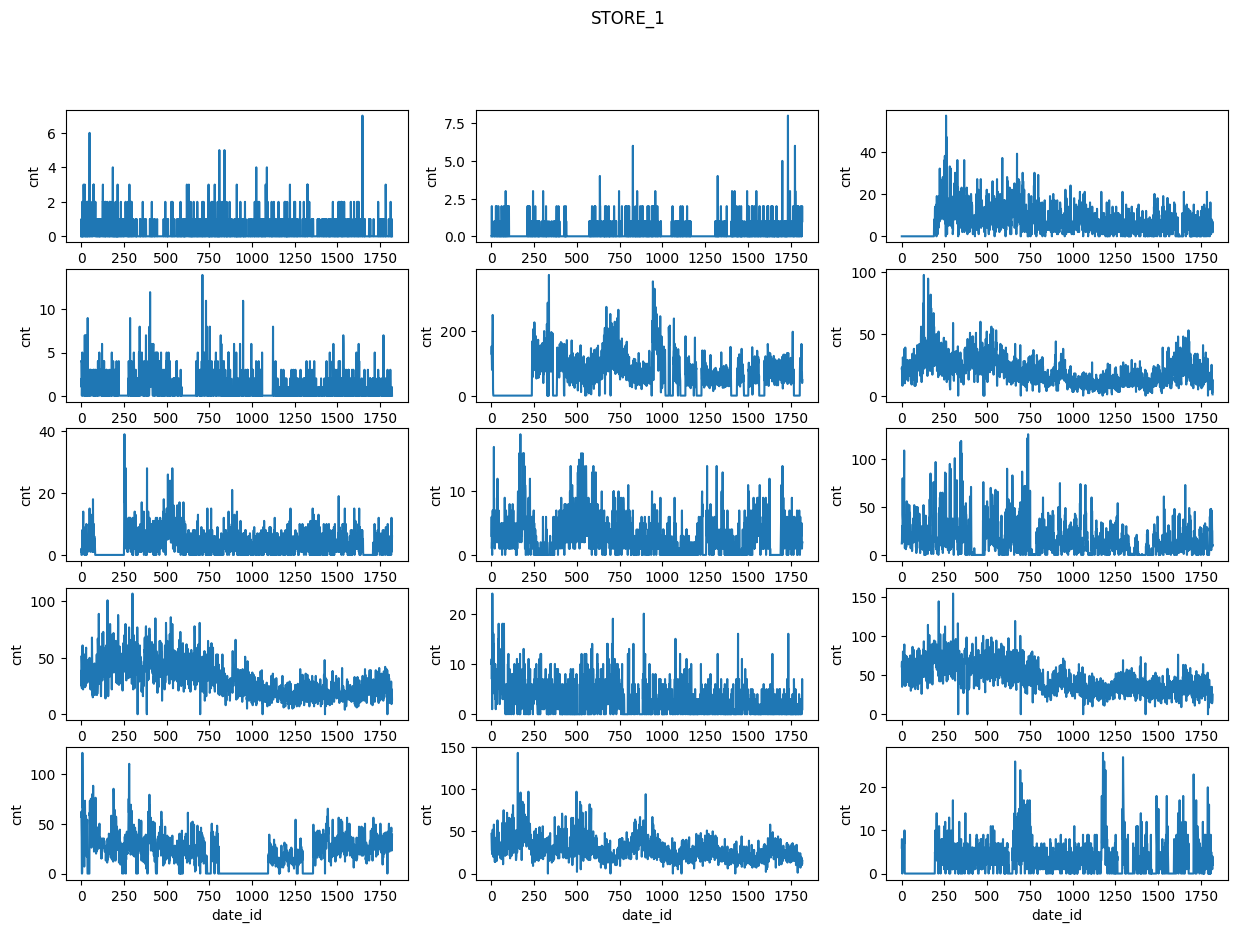

In [4]:
fig, ax = plt.subplots(5, 3, figsize=(15, 10))

for i, art in enumerate(sales[sales['store_id'] == 'STORE_1']['item_id'].unique()):
    sns.lineplot(
        data=sales[(sales['item_id'] == art) & (sales['store_id'] == 'STORE_1')],
        x='date_id',
        y='cnt',
        ax=ax[i // 3][i % 3],
    )
plt.suptitle('STORE_1');

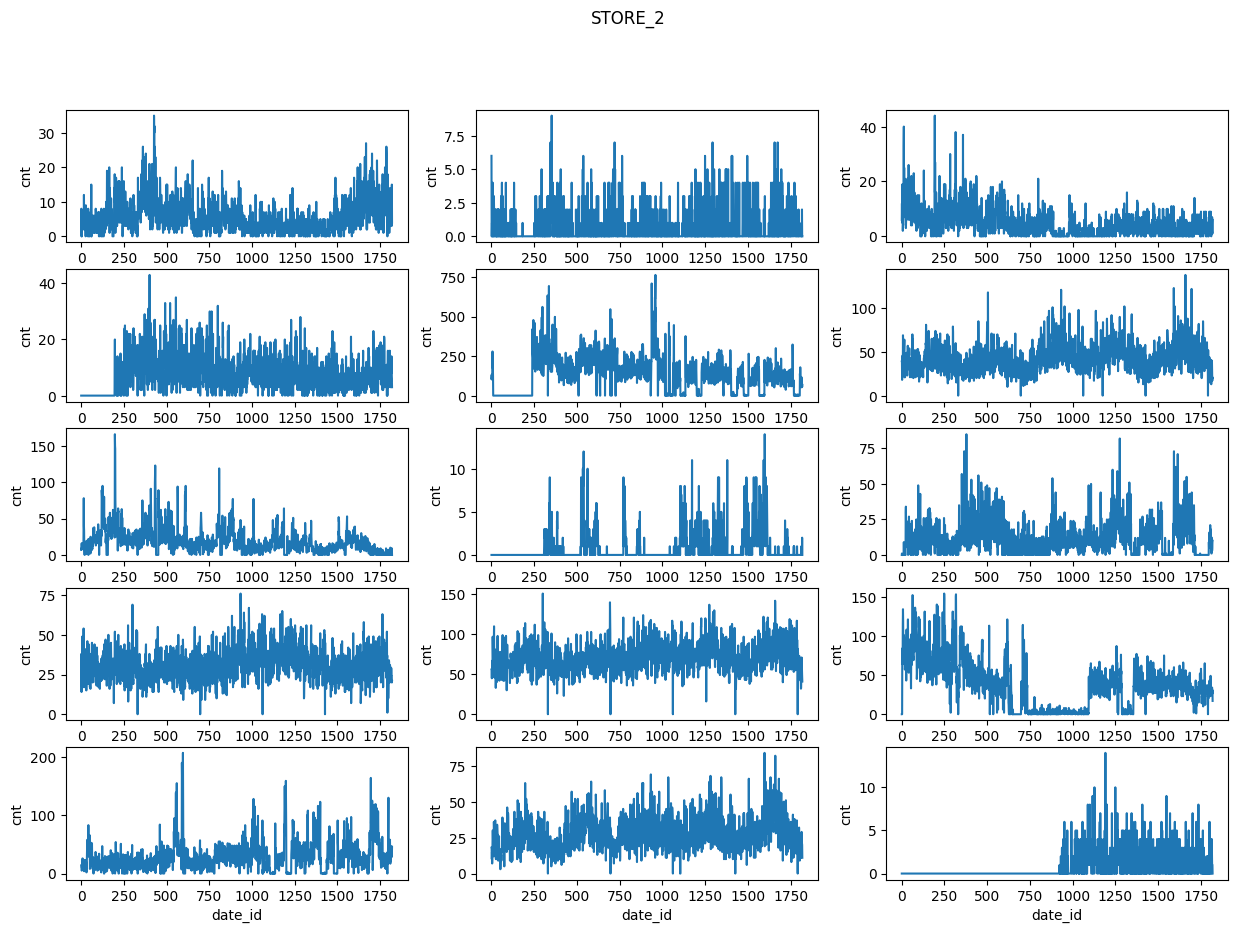

In [5]:
fig, ax = plt.subplots(5, 3, figsize=(15, 10))

for i, art in enumerate(sales[sales['store_id'] == 'STORE_2']['item_id'].unique()):
    sns.lineplot(
        data=sales[(sales['item_id'] == art) & (sales['store_id'] == 'STORE_2')],
        x='date_id',
        y='cnt',
        ax=ax[i // 3][i % 3],
    )
plt.suptitle('STORE_2');

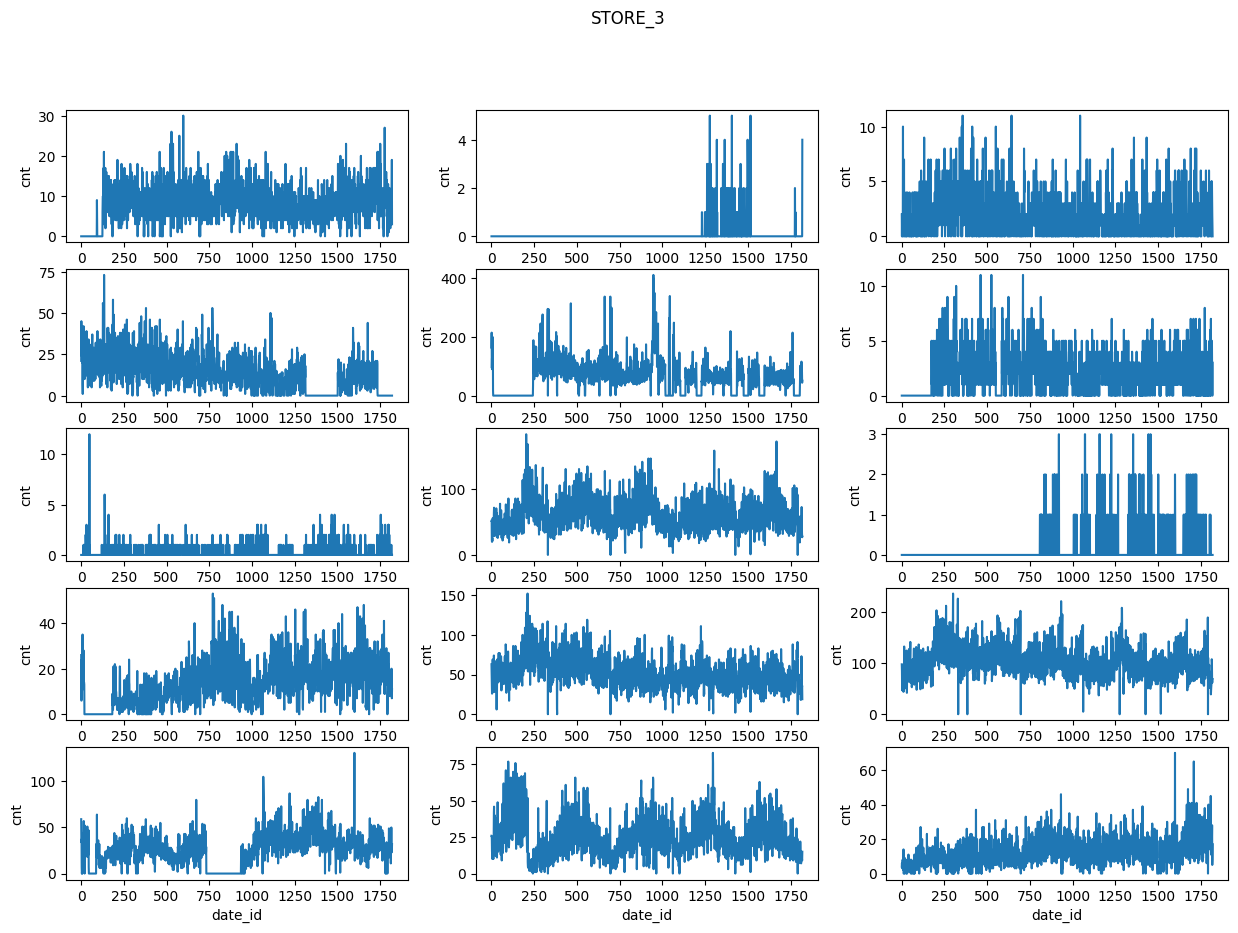

In [6]:
fig, ax = plt.subplots(5, 3, figsize=(15, 10))

for i, art in enumerate(sales[sales['store_id'] == 'STORE_3']['item_id'].unique()):
    sns.lineplot(
        data=sales[(sales['item_id'] == art) & (sales['store_id'] == 'STORE_3')],
        x='date_id',
        y='cnt',
        ax=ax[i // 3][i % 3],
    )

plt.suptitle('STORE_3');

In [7]:
# данные о датах и праздниках (соединяется с продажами по полю date_id)
calendar = pd.read_csv('../data/shop_sales_dates.csv')
calendar.tail()

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3
1814,2016-01-17,11551,Sunday,2,1,2016,NaN,NaN,NaN,NaN,1815,0,0,0
1815,2016-01-18,11551,Monday,3,1,2016,MartinLutherKingDay,National,NaN,NaN,1816,0,0,0
1816,2016-01-19,11551,Tuesday,4,1,2016,NaN,NaN,NaN,NaN,1817,0,0,0
1817,2016-01-20,11551,Wednesday,5,1,2016,NaN,NaN,NaN,NaN,1818,0,0,0
1818,2016-01-21,11551,Thursday,6,1,2016,NaN,NaN,NaN,NaN,1819,0,0,0


In [8]:
# данные о стоимости товаров (соединяется с датами по полю wm_yr_wk)
prices = pd.read_csv('../data/shop_sales_prices.csv')
prices.tail()

,store_id,item_id,wm_yr_wk,sell_price
11136,STORE_1,STORE_1_584,11551,1.00
11137,STORE_1,STORE_1_586,11551,1.68
11138,STORE_1,STORE_1_587,11551,2.48
11139,STORE_1,STORE_1_714,11551,1.58
11140,STORE_1,STORE_1_727,11551,4.48
